# Estimate $n_{\beta\beta}$

## Objective

Estimate the number of signal events using the extended maximum likelihood fit and simulated experiments

## Physics

We are going to estimate the number of signal events using a extended maximum likelihood fit. 

Similar to how we computed the number of bkg events in a blind sample, we fit the energy distribution in the energy enlarged window to the template distributions of the signal and the background (that we obtain from simulated data)

We test the fitting methods generating an experiment with a number of background events compatibles with out detector and assuming a given number of signal events.

We can vary the number of signal events to test the performance of the fit.

## Analysis

#### Importing modules

In [67]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [69]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
rootpath = os.getcwd()[:-15]
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/


In [70]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.pltfanal as pltfn    # plotting for fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objectives:

   * ***Fit the signal energy region***

### Tasks

   * Open the data file (HDF) and access the simulated data (MC) of 214Bi, 208Tl and bb0nu. 

   * Generate an experiment with a given number of signal events and a level of background compatible with the one estimated using the blind-data sample (in previous task).

   * Estimate the uncertainties in the numbe of evnets
   
### Notes

   * We are going to fit the selected events in the *erange* energy region to the three samples: $\beta\beta0\nu$, $^{214}$Bi and $^{208}$Tl.
   
   * We use an extended maximum likelihood fit of a composite PDF

## Main parameters

In [71]:
coll          = collpars.collaboration
sel_ntracks   = collpars.sel_ntracks
sel_eblob2    = collpars.sel_eblob2
sel_erange    = collpars.sel_erange
sel_eroi      = collpars.sel_eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : {:6d}'.format(sel_ntracks))
print('Blob-2 energy range       : {:6.3f}  MeV'.format(sel_eblob2))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*sel_erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*sel_eroi))

Collaboration             : new_beta
number of tracks range    :      1
Blob-2 energy range       :  0.400  MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [72]:
# list of the analisys selection variables names and ranges
ntracks_range = (sel_ntracks, sel_ntracks + 0.1)
eblob2_range  = (sel_eblob2, sel_erange[1]) # MeV

varnames  = ['num_tracks', 'blob2_E', 'E']
varranges = [ntracks_range, eblob2_range, sel_erange]
print('ana varnames  : ', varnames)
print('ana varranges : ', varranges)

# list of the reference selction variable names and rages to get pdfs for the MC
refnames  = ['num_tracks', 'E']
refranges = [ntracks_range, sel_erange]
print('ref varnames  : ', refnames)
print('ref varranges : ', refranges)


ana varnames  :  ['num_tracks', 'blob2_E', 'E']
ana varranges :  [(1, 1.1), (0.4, 2.7), (2.4, 2.7)]
ref varnames  :  ['num_tracks', 'E']
ref varranges :  [(1, 1.1), (2.4, 2.7)]


In [73]:
# number of  blind events
n_Bi_total = collpars.n_Bi_total
n_Tl_total = collpars.n_Tl_total

eff_Bi_E   = collpars.eff_Bi_E
eff_Tl_E   = collpars.eff_Tl_E
eff_bb_E   = collpars.eff_bb_E
print('Number of bkg events in full data : Bi = {:6.2f}, Tl = {:6.2f}.'.format(n_Bi_total, n_Tl_total))

Number of bkg events in full data : Bi = 1404.20, Tl = 20659.77.


## Access the data

In [74]:
# set the path to the data directory and filenames
dirpath = rootpath+'/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

# access the simulated data (DataFrames) for the different samples (Bi, Tl, bb) located in the data file
mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

# set the names of the samples
# set the names of the samples
mc_samples         = [mcbi, mctl, mcbb] # list of the mc DFs
sample_names       = ['Bi', 'Tl', 'bb']
sample_names_latex = [ r'$^{214}$Bi', r'$^{208}$Tl', r'$\beta\beta0\nu$',] # str names of the mc samples

for i, mc in enumerate(mc_samples):
    print('MC Sample {:s}, number of simulated events = {:d}'.format(sample_names[i], len(mc)))

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2//data/fanal_new_beta.h5
MC Sample Bi, number of simulated events = 60184
MC Sample Tl, number of simulated events = 687297
MC Sample bb, number of simulated events = 47636


## Check method with a mc experiment

  * Generate a MC experiments with number of events compatible with estimated number of bkg events and a hipothetical number of signal events.
  
  * Fit the energy distribution of the selected events to the samples pdfs: Bi, Tl, bb
  
  * Do a profile scan to estimate the confidence interval and p0-value for this example
  
### Notes

  * There is an appendix with the code step by step.

**Exercise**

  * Generate other experiments with different number of signal events to study the performance of the fit

In [75]:
def nevts_total(factor = 1.):
    """ returns the total number of events (Bi, Tl, bb), 
    The expected number of bb events in the RoI is a **factor = 1.** of the number of the expected Bi events in RoI
    """
    n_Bi_RoI    = collpars.n_Bi_RoI
    eff_bb_RoI  = collpars.eff_bb_RoI
    n_Bi_total  = collpars.n_Bi_total
    n_Tl_total  = collpars.n_Tl_total
    n_bb_total  = factor * n_Bi_RoI/eff_bb_RoI
    nevts       = (n_Bi_total, n_Tl_total, n_bb_total)
    return np.array(nevts)

def nevts_in_E(n_total):
    """ returns the number of expected events in the enlarged energy windows: (Bi, Tl, bb) 
    given a total number of events (Bi, Tl, bb)
    """
    eff_Bi_E      = collpars.eff_Bi_E
    eff_Tl_E      = collpars.eff_Tl_E
    eff_bb_RoI    = collpars.eff_bb_RoI
    nBi, nTl, nbb = n_total
    nevts         = (nBi * eff_Bi_E, nTl * eff_Tl_E, nbb * eff_bb_E)
    return np.array(nevts)

#### Simulate & Fit the data of an experiment

The simulated experiment expect the same number of bkg events that our experiment and a certain number of signal events

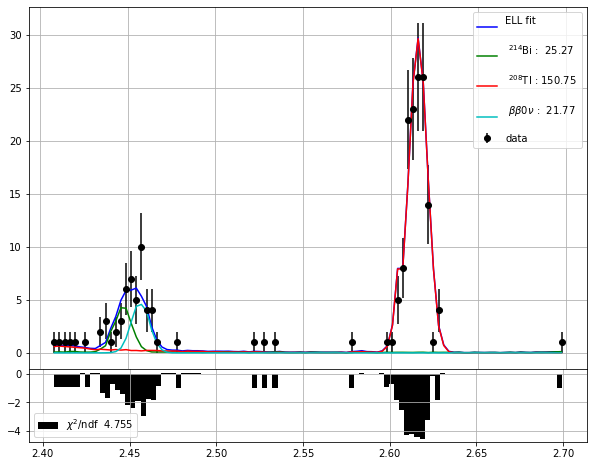

In [76]:
# set the number of events
factor      = 1.
n_total     = nevts_total(factor)
n_E         = nevts_in_E(n_total)

# define the fit
fit         = fn.prepare_fit_ell(mc_samples, n_total, varnames, varranges, refnames, refranges)

# generate an experiment using the mc samples and a given number of events of each sample
mcdata      = fn.generate_mc_experiment(mc_samples, n_total)

result, values, \
ell, n_est  = fit(mcdata)
ne_est = result.x if result.success else n_E

pltfn.plot_fit_ell(values, n_est, ell, parnames = sample_names_latex)

In [80]:
for i, ni in enumerate(n_total):
    print('Number of {:s} total events = {:6.3f}'.format(sample_names[i], ni))

for i, ni in enumerate(n_E):
    print('Number of {:s} expected events in E window = {:6.3f}'.format(sample_names[i], ni))

for i, ni in enumerate(n_est):
    print('Number of {:s} estimated events in E window = {:6.3f}'.format(sample_names[i], ni))

Number of Bi total events = 1404.203
Number of Tl total events = 20659.771
Number of bb total events = 41.936
Number of Bi expected events in E window = 25.276
Number of Tl expected events in E window = 150.816
Number of bb expected events in E window = 21.765
Number of Bi estimated events in E window = 25.268
Number of Tl estimated events in E window = 150.748
Number of bb estimated events in E window = 21.768


## Parameter uncertanties estimation


We perform a likelihood scan to estimate the parameter uncerstainties

We estimate the 60% C.L intervals

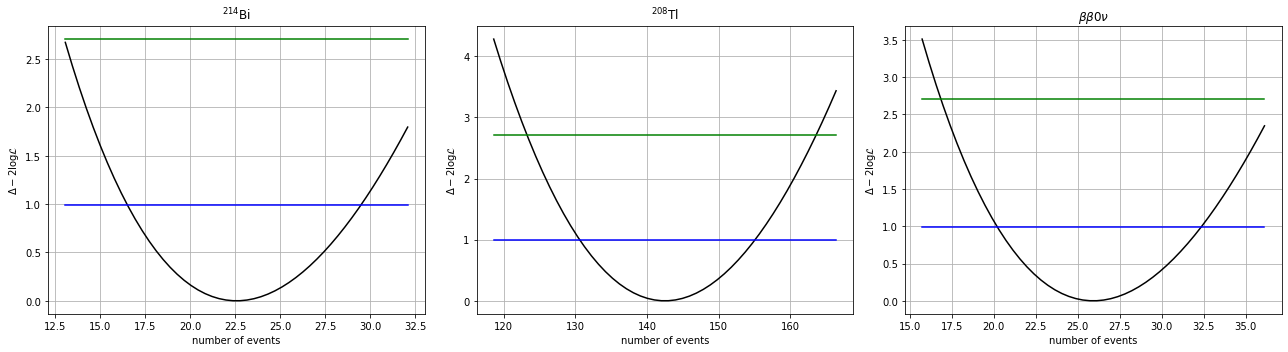

In [81]:
nis, tmus = fn.tmu_scan(values, result.x, ell, sizes = (2., 2., 2.))
pltfn.plot_tmu_scan(nis, tmus, titles = sample_names_latex)

In [58]:
cl    = 0.68
mucis = [efit.tmu_conf_int(ni, tmu, cl) for ni, tmu in zip(nis, tmus)]
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = ({:5.2f}, {:5.2f})'.format(sample_names[i], 100*cl, *ci))

Number of Bi events CI at   68 % CL = (10.28, 21.57)
Number of Tl events CI at   68 % CL = (130.87, 154.22)
Number of bb events CI at   68 % CL = (25.63, 37.97)


In [59]:
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = {:5.2f}  {:5.2f} +{:5.2f}'.format(sample_names[i], 100*cl, 
                                                                                        result.x[i],
                                                                                        *(ci - result.x[i])))

Number of Bi events CI at   68 % CL = 15.60  -5.32 + 5.97
Number of Tl events CI at   68 % CL = 142.06  -11.19 +12.16
Number of bb events CI at   68 % CL = 31.34  -5.71 + 6.63


## Null hypothesis p-value calculation

We compute the p-value of the null hypothesis (that there is no signal)

In [60]:
q0 = efit.tmu(values, ell, result.x, 0.)
z0 = np.sqrt(q0)
p0 = 1 - stats.norm.cdf(z0)
#p0 = stats.chi2.sf(q0, 1)/2.
print('H0 p value {:1.2e}, {:4.2f} sigmas'.format(p0, z0))

H0 p value 1.43e-04, 3.63 sigmas


## Estimate the half-time

We estimate the value of the half-time, $\mathcal{T}_{1/2}^{\beta\beta0\nu}$.

We use as inputs:

 * the estimated number of signal events in the enlarged energy windows (from the fit)   
 * the total efficiency of selecting signal events
 * the exposure (kg y)



The formula relating is:

$$
\mathcal{T}_{1/2}^{\beta\beta2\nu} = \frac{\delta \, \epsilon^{\beta\beta}_E \, M \, t }{n^{\beta\beta}_E} \frac{N_A \, \log(2)}{W}
$$

Where:

  * $\delta$ is the aceptance of the detector (in our detector is 0.9)
  * $\epsilon^{\beta\beta}_E$ is the efficiency of selecting signal events in the E window (in fraction, computed using the mc)
  * $M$ the mass of the detector (g)
  * $t$ the time of the exposure (y)
  * $N_A$ is the Avogadro number
  * $W$ is the atomic mass in (g)

In [83]:
from collpars import exposure

eff      = collpars.acc_bb * collpars.eff_bb_E # total signal selection efficiency in the E window
n_bb_E   = n_est[-1] # estimated number of bb  in E
tau      = fn.half_life(n_bb_E, exposure, eff) # tau_1/2

print('number of bb0nu events in E  : {:6.3f}'.format(n_bb_E))
print('exposure                     : {:6.2f} kg y'.format(exposure))
print('total signal efficiency      : {:6.3f}'.format(eff))
print('bb0nu half-life              : {:6.2e} y '.format(tau))

number of bb0nu events in E  : 21.768
exposure                     : 1000.00 kg y
total signal efficiency      :  0.410
bb0nu half-life              : 5.21e+25 y 


## Appendix: Step by step

Total number of events     : Bi = 1404.20,  Tl = 20659.77,  bb =  41.94, 
Expected number of events  : Bi =  25.28,  Tl = 150.82,  bb =  21.77, 
Fit success ?              : True
Estimated number of events : Bi =  22.71,  Tl = 136.25,  bb =  13.04, 


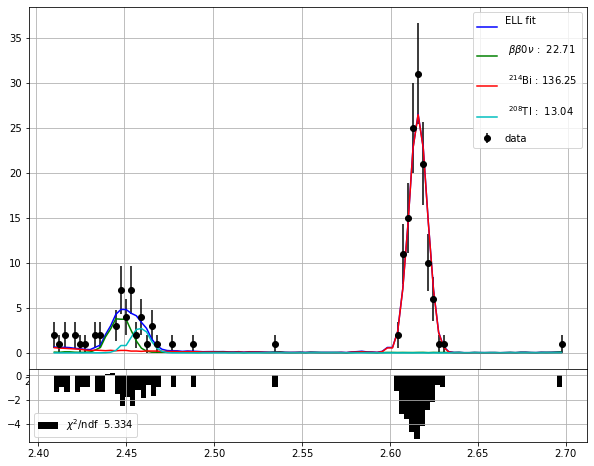

In [62]:
# set the number of events
# expected bkg events are estimated using the fit to the blind data
# consider the number of signal events a factor of the expected Bi events 
factor          = 1.
nevts           = nevts_total(factor)

# generate the ELL instace to fit the energy distribution to the energy distribution of the three mc samples
ell             = fn.get_ell(mc_samples, refnames, refranges)

# expected number of events for each mc sample
#effs            = [ut.selection_efficiency(mc, varnames, varranges)[0] for mc in mc_samples]
nevts_exp       = nevts_in_E(nevts)

# generate an experiment using the mc samples and a given number of events of each sample
mcdata          = fn.generate_mc_experiment(mc_samples, nevts)

# select the data
datana          = ut.selection_sample(mcdata, varnames, varranges)

# fit the energy values of the data 
values          = datana['E'].values
result          = ell.best_estimate(values, *nevts_exp)
nevts_est       = result.x

# plot the results
pltfn.plot_fit_ell(values, nevts_est, ell)

# print out
print('Total number of events     :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(sample_names, nevts)])
print('Expected number of events  :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(sample_names, nevts_exp)])

print('Fit success ?              :', result.success)
print('Estimated number of events :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(sample_names, nevts_est)])